In [1]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

# 📈 Estrategia: Reversión a la Media con Bandas de Bollinger 

Utilizaremos las **Bandas de Bollinger (BB)** combinadas con una **Media Móvil Simple (SMA)** de tendencia a largo plazo.
Operaremos el **EURUSD** en temporalidad de **1 hora**

**Lógica de Operativa:**
* **Tendencia:** Filtramos operaciones basándonos en una SMA de largo plazo (`trend_sma_period`).
* **Entradas:** Buscamos desviaciones del precio respecto a las bandas (reversión).
* **Salidas:** Cerramos posición cuando el precio retorna a su media (`bb_basis`).

Optimizaremos los parámetros de `trend_sma_period` y `window` de las Bandas de Bollinguer dentro del conjunto de datos de entrenamineto.

---

In [2]:
import pandas as pd
from backtesting import Backtest, Strategy

def get_sma(data, period):
    return pd.Series(data).rolling(period).mean()

def get_bb_upper(data, window, n_std):
    sma = pd.Series(data).rolling(window).mean()
    std = pd.Series(data).rolling(window).std()
    return sma + (std * n_std)

def get_bb_lower(data, window, n_std):
    sma = pd.Series(data).rolling(window).mean()
    std = pd.Series(data).rolling(window).std()
    return sma - (std * n_std)


class BBMeanReversion(Strategy):
    # params
    window = 20
    n_std = 2
    trend_sma_period = 200 

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init(self):
        # create indicators
        self.trend_sma = self.I(get_sma, self.data.Close, self.trend_sma_period)
        self.bb_upper = self.I(get_bb_upper, self.data.Close, self.window, self.n_std)
        self.bb_lower = self.I(get_bb_lower, self.data.Close, self.window, self.n_std)
        self.bb_basis = self.I(get_sma, self.data.Close, self.window) # this is the mean in the bollinguer

        self.cross_low_bb = False
        self.cross_upper_bb = False

    def next(self):
        price = self.data.Close[-1]
        
        # --- EXITS ---
        if self.position.is_long and price >= self.bb_basis[-1]:
            self.position.close()
            return

        if self.position.is_short and price <= self.bb_basis[-1]:
            self.position.close()
            return

        # --- LONG LOGIC --- if price above trend sma
        if price > self.trend_sma[-1]:
            # reset oppositve flag for security 
            self.cross_upper_bb = False 

            # price under bb lower
            if not self.position and price < self.bb_lower[-1]:
                self.cross_low_bb = True
            
            # if it recovers, buy
            elif self.cross_low_bb and price >= self.bb_lower[-1]:
                self.buy(size = 0.9)
                self.cross_low_bb = False

        # --- SHORT LOGIC --- if price under tren sma
        elif price < self.trend_sma[-1]: 
            self.cross_low_bb = False

            if not self.position and price > self.bb_upper[-1]:
                self.cross_upper_bb = True
            
            elif self.cross_upper_bb and price <= self.bb_upper[-1]:
                self.sell(size = 0.9)
                self.cross_upper_bb = False
        
        

# load data
data = pd.read_csv("EURUSD_H1.csv", sep="\t")

# set index time
data = data.set_index("Time")

data.index = pd.to_datetime(data.index).tz_localize(None)

# remove nans
data = data.dropna()
data = data.astype(float)

# split Train/Test 
train_size = 0.85
cut_point = int(len(data) * train_size)

# define train and test data
train_data = data.iloc[:cut_point]
test_data = data.iloc[cut_point:]

Loading BokehJS ...

## ⚙️ Optimización de Parámetros (In-Sample)

Antes de validar el sistema, buscaremos la combinación de parámetros que maximice nuestro rendimiento ajustado al riesgo.

<div style="padding: 15px;">
  <strong>🎯 Objetivo:</strong> Maximizar el <b>Sharpe Ratio</b>.<br>
  <strong>🔍 Variables a optimizar:</strong> Periodo de la SMA de tendencia y la ventana de las Bandas de Bollinger.
</div>
<br>

In [ ]:
leverage = 5
margin_rate = 1 / leverage

bt = Backtest(train_data, BBMeanReversion, cash=10000, commission=.0, exclusive_orders=True,margin=margin_rate)

stats = bt.optimize(
    trend_sma_period = [150,175,200,225,250], 
    window = [15, 20, 25],
    maximize="Sharpe Ratio",
)

optimmal_window = stats._strategy.window
optimal_trned_sma_peridod = stats._strategy.trend_sma_period


In [4]:
print("\n--- Resultados Óptimos ---")
print("Mejor Ventana BB:",optimmal_window )
print("Mejor Trend SMA:",optimal_trned_sma_peridod )
print(f"Sharpe Ratio: {stats['Sharpe Ratio']:.2f}")
print("\n========= Resultados del Backtest ===========")
print(stats)
    


--- Resultados Óptimos ---
Mejor Ventana BB: 15
Mejor Trend SMA: 175
Sharpe Ratio: 0.34

========= Resultados del Backtest ===========
Start                     2009-11-26 01:00:00
End                       2023-07-11 14:00:00
Duration                   4975 days 13:00:00
Exposure Time [%]                    16.57882
Equity Final [$]                  22395.59011
Equity Peak [$]                   27291.40433
Return [%]                           123.9559
Buy & Hold Return [%]               -26.11484
Return (Ann.) [%]                     4.88276
Volatility (Ann.) [%]                14.41885
CAGR [%]                              4.16815
Sharpe Ratio                          0.33864
Sortino Ratio                         0.46376
Calmar Ratio                          0.15957
Alpha [%]                           123.37309
Beta                                 -0.02232
Max. Drawdown [%]                   -30.59989
Avg. Drawdown [%]                    -2.12617
Max. Drawdown Duration     1214 days

## 🧪 Validación Out-of-Sample (Test Set)

Una vez encontrados los parámetros óptimos en el conjunto de entrenamiento, es crucial validar la estrategia en datos no vistos (**Test Set**) para evitar el *overfitting*.

> **Nota:** Los resultados a continuación representan el comportamiento esperado del sistema en un entorno desconocido.

In [11]:
bt_test = Backtest(data = test_data,strategy=BBMeanReversion,commission=.0, exclusive_orders=True,margin=margin_rate)

results = bt_test.run()

print(results)

Start                     2023-07-11 15:00:00
End                       2025-12-05 21:00:00
Duration                    878 days 06:00:00
Exposure Time [%]                       15.96
Equity Final [$]                   10611.7004
Equity Peak [$]                   11097.77443
Return [%]                              6.117
Buy & Hold Return [%]                 4.58834
Return (Ann.) [%]                     2.00683
Volatility (Ann.) [%]                 9.32361
CAGR [%]                              1.71818
Sharpe Ratio                          0.21524
Sortino Ratio                         0.27697
Calmar Ratio                          0.16569
Alpha [%]                              6.3712
Beta                                  -0.0554
Max. Drawdown [%]                   -12.11171
Avg. Drawdown [%]                    -1.35206
Max. Drawdown Duration      471 days 17:00:00
Avg. Drawdown Duration       27 days 19:00:00
# Trades                                  184
Win Rate [%]                      

# 📊 Análisis de Robustez: Bootstrap de Retornos

La media de retornos de un backtest es solo una realización de muchas posibles. Para conocer la **esperanza matemática real** de nuestro sistema, utilizaremos técnicas de remuestreo (Bootstrap).

Aplicaremos dos métodos para calcular los intervalos de confianza al 95%:
1.  **Método Simple (Percentiles):** Asume simetría en la distribución.
2.  **Método BCa (Bias-Corrected Accelerated):** Corrige el sesgo y la asimetría de la distribución, ofreciendo un resultado mucho más riguroso para series financieras.

---

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# compute log of equity curve
log_equity_curve = np.log(results["_equity_curve"]["Equity"])
# take changes
changes = log_equity_curve.diff().to_list()

# create the array where we will store all the returns
returns = []

for trade in results["_trades"].iterrows():
    trade = trade[1]
    entry_bar = trade["EntryBar"]
    exit_bar = trade["ExitBar"]
    # add the new returns to the array
    returns = returns + changes[entry_bar:exit_bar]


Media Original: 0.002643%
Límite Inferior (Simple 5%): -0.013433%
Límite Inferior (BCa 5%): -0.013287%
Probabilidad de media positiva: 62.60%


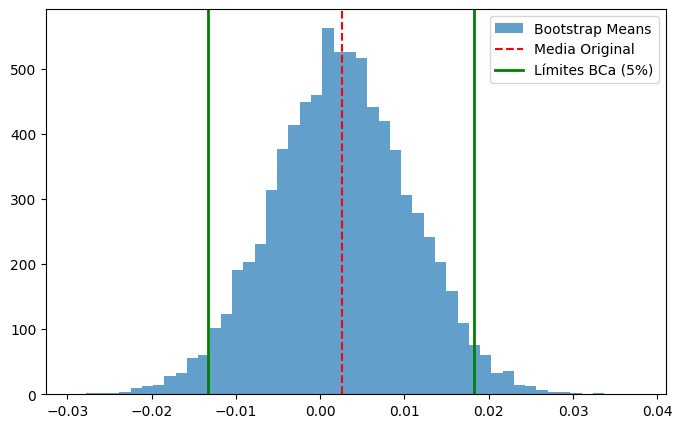

In [10]:
# number of samples
B = 8000
n = len(returns)
alpha = 0.05

def simple_interval(boot_means,aplha):
    lower_bound  = np.percentile(boot_means, 100 * aplha / 2)
    upper_bound = np.percentile(boot_means, 100 - 100 * aplha / 2)

    return lower_bound,upper_bound

def bias_corrected_accelerated_interval(boot_means,original_mean,alpha):
    prop_less = np.sum(boot_means < original_mean) / B
    z0 = norm.ppf(prop_less)

    # apply jackknife tecnique
    sum_total = np.sum(returns)
    jackknife_means = (sum_total - returns) / (n - 1) 
    mean_jack = np.mean(jackknife_means)

    numer = np.sum((mean_jack - jackknife_means)**3)
    denom = 6.0 * (np.sum((mean_jack - jackknife_means)**2))**1.5
    a = numer / denom

    boot_means_sorted = np.sort(boot_means)

    z_alpha = norm.ppf(alpha / 2)
    num = z0 + z_alpha
    denom_adj = 1 - a * num
    z_adjusted = z0 + (num / denom_adj)
    
    alpha_prime = norm.cdf(z_adjusted)

    k_lower = int(alpha_prime * (B + 1))
    k_upper = int((1 - alpha_prime)*(B+1))
    
    return boot_means_sorted[k_lower],boot_means_sorted[k_upper]

# compute original mean
original_mean = np.mean(returns)

# create all the samples
samples = np.random.choice(returns, size = (B,n),replace = True)

# now lets compute the mean
boot_means = samples.mean(axis = 1)

# compute the intervals with both methods
simple_lb, simple_ub = simple_interval(boot_means,alpha)
BCa_lb, BCa_ub = bias_corrected_accelerated_interval(boot_means,original_mean,alpha)

# define the transformation from log returns to pct returns
transform_to_pct = lambda x: (np.exp(x) - 1) * 100


print(f"Media Original: {transform_to_pct(original_mean):.6f}%")
print(f"Límite Inferior (Simple 5%): {transform_to_pct(simple_lb):.6f}%")
print(f"Límite Inferior (BCa 5%): {transform_to_pct(BCa_lb):.6f}%")
print(f"Probabilidad de media positiva: {100 * np.sum(boot_means > 0) / B:.2f}%")

# Visualización
plt.figure(figsize=(8,5))
plt.hist(transform_to_pct(boot_means), bins=50, alpha=0.7, label='Bootstrap Means')
plt.axvline(transform_to_pct(original_mean), color='red', linestyle='--', label='Media Original')
plt.axvline(transform_to_pct(BCa_lb), color='green', linewidth=2, label='Límites BCa (5%)')
plt.axvline(transform_to_pct(BCa_ub), color='green', linewidth=2)
plt.legend()
plt.show()

# 📉 Gestión de Riesgo: Análisis de Drawdowns

El *Drawdown* es el riesgo más crítico para la psicología del inversor y la supervivencia de la cuenta. No basta con mirar el "Max Drawdown" del pasado; debemos estimar qué tan malo podría llegar a ser en el futuro. Nos podemos plantear las siguientes preguntas:

1.  🛑 **Validación:** ¿Es el drawdown actual aceptable o deberíamos descartar el sistema?
2.  🦢 **Cisne Negro:** ¿Cuál es la probabilidad de sufrir un drawdown catastrófico no visto en el backtest?
3. ▶ **Monitorización:** Si lanzamos el sistema en *Live*, ¿estamos dentro de los parámetros de riesgo esperados o el sistema se ha "roto"?

A continuación, aplicaremos un **Bootstrap Anidado (Nested Bootstrap)** con simulaciones de Monte Carlo para responder estas preguntas con rigor estadístico.

In [ ]:
def calculate_max_dd_log(equity_curve_log):
    peak = np.maximum.accumulate(equity_curve_log)
    drawdown = peak - equity_curve_log
    return np.max(drawdown)

def drawdown_fractile_montecarlo(returns, n_trades, n_reps, dd_conf):
    # create the samples from the returns
    samples = np.random.choice(returns,size=(n_reps, n_trades),replace = True)
    
    # create equity curves
    paths = np.cumsum(samples, axis=1)
    
    # compute maximum drawdown for each row
    peaks = np.maximum.accumulate(paths, axis=1)
    dds = peaks - paths
    max_dds = np.max(dds, axis=1)

    max_dds.sort()
    k = int(dd_conf * (n_reps + 1)) - 1
    k = max(0, min(k, n_reps - 1))
    
    return max_dds[k]

def bootstrap_bca_drawdown(original_returns, n_trades, n_boot, n_reps, dd_conf, boot_conf):
    n = len(original_returns)
    
    # compute the pertencile 5 for our original returns
    theta_hat = drawdown_fractile_montecarlo(original_returns, n_trades, n_reps, dd_conf)
    # create the different samples
    boot_samples = np.random.choice(original_returns, size=(n_boot, n),replace=True)
    # compute for each different sample the fractile 
    boot_thetas = [drawdown_fractile_montecarlo(sample,n_trades,n_reps,dd_conf) for sample in boot_samples]
    
    # now apply the bias corrected accelerated bootstrap
    prop_less = np.sum(boot_thetas < theta_hat) / n_boot
    z0 = norm.ppf(prop_less)
    
    jack_means = []
    for i in range(0, n, 10): # subsampling for each ten for speed
        jack_sample = np.delete(original_returns, i)
        jack_means.append(drawdown_fractile_montecarlo(jack_sample, n_trades, n_reps, dd_conf))
    jack_means = np.array(jack_means)
    mean_jack = np.mean(jack_means)
    num = np.sum((mean_jack - jack_means)**3)
    den = 6.0 * (np.sum((mean_jack - jack_means)**2))**1.5
    a = num / den if den != 0 else 0
    
    z_alpha = norm.ppf(boot_conf) 
    num = z0 + z_alpha
    den_adj = 1 - a * num
    if den_adj == 0: den_adj = 1e-6 # avoid dividing by zero
    
    z_adjusted = z0 + (num / den_adj)
    alpha_prime = norm.cdf(z_adjusted)
    
    boot_thetas.sort()
    k = int(alpha_prime * (n_boot + 1)) - 1
    k = max(0, min(k, n_boot - 1))
    
    return theta_hat, boot_thetas[k]


equity_curve = results['_equity_curve']['Equity']

log_equity = np.log(equity_curve)
log_returns = np.diff(log_equity)

active_returns = log_returns[log_returns != 0.0]

# define de number of trades (6240 is number of 1H bar in a year)
N_TRADES = int(6240 * results["Exposure Time [%]"] / 100)

N_BOOT = 1000 # for bootstraping
N_REPS = 1000 # for montecarlo

BOOT_CONF = 0.90 
DD_CONF = 0.95  
 

theta_log, bound_log = bootstrap_bca_drawdown(
    active_returns, N_TRADES, N_BOOT, N_REPS, DD_CONF, BOOT_CONF
)

theta_pct = 100 * (1 - np.exp(-theta_log))
bound_pct = 100 * (1 - np.exp(-bound_log))

print("\n" + "="*50)
print(f"RESULTADOS PARA PERIODO DE {N_TRADES} VELAS ACTIVAS")
print("="*50)
print(f"Drawdown Estimado Puntual: {theta_pct:.2f}%")
print(f"Límite Superior BCa ({BOOT_CONF*100}% Confianza): {bound_pct:.2f}%")
print("-" * 50)
print(f"INTERPRETACIÓN:")
print(f"Hay un {BOOT_CONF*100}% de probabilidad estadística de que")
print(f"el drawdown real al nivel {DD_CONF*100}% (evento raro)")
print(f"NO exceda el {bound_pct:.2f}%.")
print("="*50)

plt.figure(figsize=(10,6))
plt.plot(equity_curve.values)
plt.title("Curva de Equity OOS")
plt.show()